In [124]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import math

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [3]:
dtp_df = pd.read_csv("../Data/SpbData/ProcessingData/dtp_with_boundaries_check.csv")

In [4]:
dtp_df.loc[~dtp_df.in_city_boundaries, 'COORD_L'] = dtp_df[~dtp_df.in_city_boundaries].lng.tolist()
dtp_df.loc[~dtp_df.in_city_boundaries, 'COORD_W'] = dtp_df[~dtp_df.in_city_boundaries].lat.tolist()

In [5]:
geometry = [Point(xy) for xy in zip(dtp_df.COORD_L, dtp_df.COORD_W)]
df = dtp_df.drop(['lat', 'lng'], axis=1)
crs = {'init': 'epsg:4326'}
dtp_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [6]:
dtp_gdf = dtp_gdf.dropna(subset=['COORD_L', 'COORD_W'])

In [7]:
spb_boundaries_gdf = gpd.read_file('../Gis/layers/spb_city_boundary.geojson')
spb_boundaries_gdf = spb_boundaries_gdf.drop([1,2])

In [8]:
is_dtp_in_boundaries = dtp_gdf.intersects(spb_boundaries_gdf.unary_union)

In [9]:
dtp_in_city_bound_gdf = dtp_gdf[is_dtp_in_boundaries]

In [10]:
crossroads_gdf = gpd.read_file('../Gis/layers/spb_crossing_simplefied.geojson')

In [14]:
crossroads_gdf = crossroads_gdf.to_crs({'init': 'epsg:32636'})

In [31]:
crossroads_buffer_gdf = gpd.GeoDataFrame(gpd.GeoSeries(crossroads_gdf.buffer(100)))
crossroads_buffer_gdf = crossroads_buffer_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')

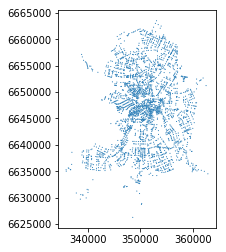

In [37]:
crossroads_buffer_gdf.plot()

In [20]:
dtp_gdf = dtp_gdf.to_crs({'init': 'epsg:32636'})

In [39]:
dtp_in_crossroads = gpd.sjoin(dtp_gdf, crossroads_buffer_gdf, how="inner", op='intersects')

In [60]:
#dtp_in_crossroads = dtp_in_crossroads.drop('in_city_boundaries',axis=1)
dtp_in_crossroads.to_file("../Gis/layers/dtp_in_crosroads_2.geojson", driver='GeoJSON')

In [47]:
POG = dtp_in_crossroads.groupby('index_right')['POG'].sum().sort_values()
RAN = dtp_in_crossroads.groupby('index_right')['RAN'].sum().sort_values()
DTP_COUNT = dtp_in_crossroads.groupby('index_right')['KartId'].count().sort_values()

In [104]:
dtp_in_crossroads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9968 entries, 2 to 21014
Data columns (total 30 columns):
Unnamed: 0           9968 non-null int64
Unnamed: 0.1         9968 non-null int64
COORD_L              9968 non-null float64
COORD_W              9968 non-null float64
DTP_V                9968 non-null object
District             9968 non-null object
K_TS                 9968 non-null int64
K_UCH                9968 non-null int64
KartId               9968 non-null int64
POG                  9968 non-null int64
RAN                  9968 non-null int64
Time                 9968 non-null object
change_org_motion    9968 non-null object
date                 9968 non-null object
dor                  16 non-null object
dor_k                19 non-null float64
dor_z                9968 non-null object
house                9923 non-null object
k_ul                 9957 non-null object
km                   45 non-null float64
m                    45 non-null float64
n_p         

In [129]:
dtp_in_crossroads_simplify = dtp_in_crossroads[['K_UCH','POG','RAN', 'index_right', 'KartId']]
UCH_ALL = dtp_in_crossroads_simplify.K_UCH.sum()
POG_ALL = dtp_in_crossroads_simplify.POG.sum()
RAN_ALL = dtp_in_crossroads_simplify.RAN.sum()
DTP_COUNT = len(dtp_in_crossroads_simplify)

In [127]:
f = {'POG':['sum'], 'RAN':['sum'], 'K_UCH':['sum'], 'KartId':['count']}
grouped_dtp = dtp_in_crossroads_simplify.groupby('index_right').agg(f)

In [135]:
grouped_dtp['POG']['sum']

index_right
0       0
1       0
2       0
3       0
4       0
5       0
7       0
8       0
9       0
10      0
11      0
12      0
13      1
14      0
15      0
17      2
18      0
19      0
20      0
22      0
23      0
24      0
28      0
29      0
30      0
31      0
34      0
35      1
37      0
38      0
       ..
2820    0
2822    0
2823    0
2824    0
2825    0
2830    0
2832    0
2833    0
2834    0
2835    0
2836    0
2838    0
2840    1
2841    0
2844    0
2846    0
2847    0
2848    0
2849    0
2850    0
2852    0
2853    0
2854    0
2857    0
2858    0
2860    0
2865    0
2866    0
2867    0
2868    0
Name: sum, Length: 2252, dtype: int64

In [144]:
dang_index = []
for g in grouped_dtp.iterrows():
    r = g[1]
    
    d_index = math.sqrt((r['POG']['sum'] * (UCH_ALL/POG_ALL))**2 + (r['RAN']['sum'] * (UCH_ALL/RAN_ALL))**2 + (r['KartId']['count'] * (UCH_ALL/DTP_COUNT))**2)
    dang_index.append(d_index)    

#grouped_dtp['dang_index'] = grouped_dtp.apply(lambda r: math.sqrt((r['POG']['sum'] * (UCH_ALL/POG_ALL))^2 + (r['RAN']['sum'] * (UCH_ALL/RAN_ALL))^2 + (r['KartId']['count'] * (UCH_ALL/DTP_COUNT))^2)) 

In [145]:
grouped_dtp['dang_index'] = dang_index

In [147]:
grouped_dtp.sort_values('dang_index', ascending=False)

,POG,RAN,K_UCH,KartId,dang_index
,sum,sum,sum,count,
index_right,,,,,
303,3,14,29,12,255.991189
58,3,7,23,10,254.274419
1671,3,2,6,2,252.807964
2039,2,51,90,26,208.078896
1115,0,65,148,55,187.933708
638,2,29,59,23,187.073659
1147,2,27,53,17,182.042954
857,2,23,49,19,180.851982


In [49]:
crossroads_gdf_wgs_84 = crossroads_gdf.to_crs({'init': 'epsg:4326'})

In [154]:
crossroads_gdf_wgs_84.iloc[1274]

id                                                       node/233459
@id                                                      node/233459
crossing                                                uncontrolled
highway                                                     crossing
horse                                                               
traffic_calming                                                     
sloped_curb                                                         
crossing:light                                                      
railway                                                             
tactile_paving                                                      
supervised                                                          
traffic_signals:sound                                               
traffic_signals                                                     
railway:type                                                        
button_operated                   